In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve

import numba

from tqdm import tqdm

In [2]:
img1 = cv2.imread('files/ostriches.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = img1.astype('float32')

img2 = cv2.imread('files/castle.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = img2.astype('float32')

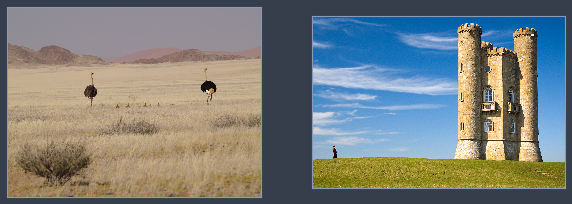

In [3]:
plt.figure(figsize=(10,12))

plt.subplot(121)
plt.imshow(img1 / 255)
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(img2 / 255)
plt.xticks([]), plt.yticks([])

plt.show()

In [4]:
sobel_x = np.array([[-1., 0., 1.],
                    [-2., 0., 2.],
                    [-1., 0., 1.]])

sobel_y = np.array([[1., 2., 1.],
                    [0., 0., 0.],
                    [-1., -2., -1.]])

In [5]:
sobel_x_rgb = np.stack([sobel_x] * 3, axis=2)
sobel_y_rgb = np.stack([sobel_y] * 3, axis=2)

In [6]:
def calculate_gradients(image):
    gradients = np.absolute(convolve(image, sobel_x_rgb)) + np.absolute(convolve(image, sobel_y_rgb))
    return gradients.sum(axis=2)

In [7]:
gradients_1 = calculate_gradients(img1)
gradients_2 = calculate_gradients(img2)

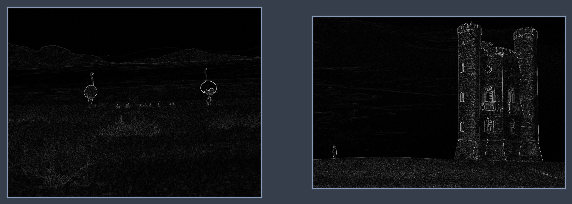

In [8]:
plt.figure(figsize=(10,12))

plt.subplot(121)
plt.imshow(gradients_1, cmap='gray')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(gradients_2, cmap='gray')
plt.xticks([]), plt.yticks([])

plt.show()

In [9]:
@numba.jit
def calculate_energy_backward(gradients):
    energy = np.zeros_like(gradients)
    
    rows = energy.shape[0]
    cols = energy.shape[1]
    
    energy[0] = gradients[0]
    
    for i in range(1, rows):
        for j in range(0, cols):
            if j == 0:
                energy[i, j] = gradients[i, j] + min(energy[i-1, j:j+2])
            elif j == cols - 1:
                energy[i, j] = gradients[i, j] + min(energy[i-1, j-1:j+1])
            else:
                energy[i, j] = gradients[i, j] + min(energy[i-1, j-1:j+2])
    return energy

In [10]:
energy_backward_1 = calculate_energy_backward(gradients_1)
energy_backward_2 = calculate_energy_backward(gradients_2)

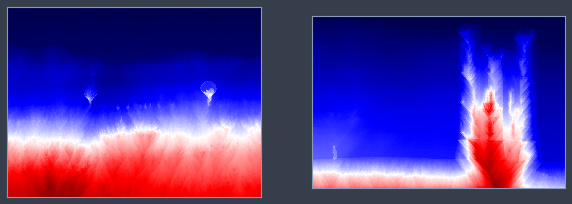

In [11]:
plt.figure(figsize=(10,12))

plt.subplot(121)
plt.imshow(energy_backward_1, cmap='seismic')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(energy_backward_2, cmap='seismic')
plt.xticks([]), plt.yticks([])

plt.show()

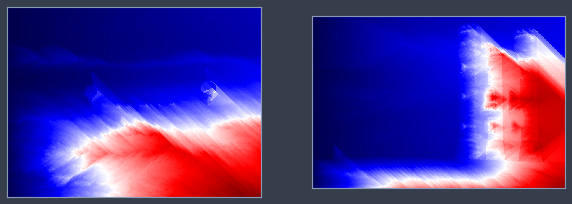

In [12]:
plt.figure(figsize=(10,12))

plt.subplot(121)
plt.imshow(np.rot90(calculate_energy_backward(np.rot90(gradients_1,-1))), cmap='seismic')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(np.rot90(calculate_energy_backward(np.rot90(gradients_2,-1))), cmap='seismic')
plt.xticks([]), plt.yticks([])

plt.show()

In [13]:
@numba.jit
def calculate_cumulatives(gradients):
    cumulative_l = np.zeros_like(gradients)
    cumulative_u = np.zeros_like(gradients)
    cumulative_r = np.zeros_like(gradients)
    
    rows = gradients.shape[0]
    cols = gradients.shape[1]
    
    cumulative_l[0] = gradients[0]
    cumulative_u[0] = gradients[0]
    cumulative_r[0] = gradients[0]
        
    for i in range(1, rows):
        for j in range(0, cols):
            if j == 0:
                cumulative_l[i, j] = (np.abs(gradients[i-1, j]) + np.abs(gradients[i, j+1]))
                
                cumulative_u[i, j] = (np.abs(gradients[i, j+1] - gradients[i, j])
                                      + np.abs(gradients[i-1, j+1]))
                
                cumulative_r[i, j] = (np.abs(gradients[i, j+1]) 
                                      + np.abs(gradients[i-1, j] - gradients[i, j+1]))

            elif j == cols - 1:
                cumulative_l[i, j] = (np.abs(gradients[i, j-1] - gradients[i-1, j]) 
                                      + np.abs(gradients[i, j-1]))
                
                cumulative_u[i, j] = (np.abs(gradients[i, j-1]) + np.abs(gradients[i-1, j-1]))
                
                cumulative_r[i, j] = (np.abs(gradients[i, j-1]) + np.abs(gradients[i-1, j]))

            else:
                cumulative_l[i, j] = (np.abs(gradients[i, j-1] - gradients[i-1, j]) 
                                      + np.abs(gradients[i, j-1] - gradients[i, j+1]))
                
                cumulative_u[i, j] = (np.abs(gradients[i, j+1] - gradients[i, j-1]) 
                                      + np.abs(gradients[i-1, j-1] - gradients[i-1, j+1]))
                
                cumulative_r[i, j] = (np.abs(gradients[i, j-1] - gradients[i, j+1]) 
                                      + np.abs(gradients[i-1, j] - gradients[i, j+1]))

    return cumulative_l, cumulative_u, cumulative_r

In [14]:
@numba.jit
def calculate_energy_forward(gradients):
    energy = np.zeros_like(gradients)
    
    rows = energy.shape[0]
    cols = energy.shape[1]
    
    cumulative_l, cumulative_u, cumulative_r = calculate_cumulatives(gradients)
    
    for i in range(1, rows):
        for j in range(0, cols):
            if j == 0:
                energy[i, j] = min(energy[i-1, j] + cumulative_u[i, j], energy[i-1, j+1] + cumulative_r[i, j])
            elif j == cols - 1:
                energy[i, j] = min(energy[i-1, j-1] + cumulative_l[i, j], energy[i-1, j] + cumulative_u[i, j])
            else:
                energy[i, j] = min(energy[i-1, j-1] + cumulative_l[i, j],
                                   energy[i-1, j] + cumulative_u[i, j],
                                   energy[i-1, j+1] + cumulative_r[i, j])

    return energy

In [15]:
energy_forward_1 = calculate_energy_forward(gradients_1)
energy_forward_2 = calculate_energy_forward(gradients_2)

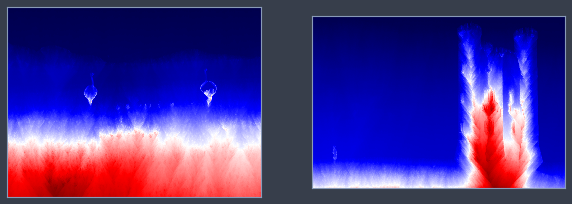

In [16]:
plt.figure(figsize=(10,12))

plt.subplot(121)
plt.imshow(energy_forward_1, cmap='seismic')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(energy_forward_2, cmap='seismic')
plt.xticks([]), plt.yticks([])

plt.show()

In [17]:
def calculate_seam(energy):
    seam = np.ones_like(energy, dtype=np.bool)
    
    min_energy = np.argmin(energy[-1])
    
    seam[-1, min_energy] = False
    
    rows = seam.shape[0]
    cols = seam.shape[1]
    
    for i in range(rows - 2, -1, -1):
        if min_energy == 0:
            min_energy = np.argmin(energy[i-1, min_energy:min_energy+2]) + min_energy
        elif min_energy == cols - 1:
            min_energy = np.argmin(energy[i-1, min_energy-1:min_energy+1]) + min_energy - 1
        else:
            min_energy = np.argmin(energy[i-1, min_energy-1:min_energy+2]) + min_energy - 1
        seam[i, min_energy] = False
        
    seam = np.stack([seam] * 3, axis=2)
    return seam

In [18]:
seam_backward_1 = calculate_seam(energy_backward_1)
seam_backward_2 = calculate_seam(energy_backward_2)

seam_forward_1 = calculate_seam(energy_forward_1)
seam_forward_2 = calculate_seam(energy_forward_2)

In [19]:
def carve(seam, image):
    rows = image.shape[0]
    cols = image.shape[1]
    return image[seam].reshape(rows, cols - 1, 3)

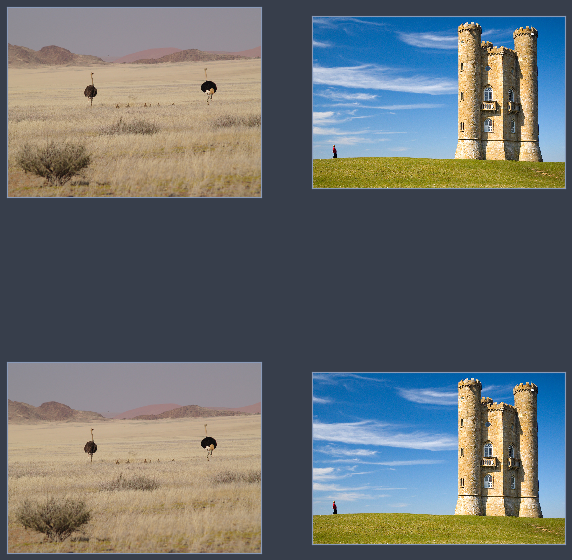

In [20]:
plt.figure(figsize=(10,12))

plt.subplot(221)
plt.imshow(carve(seam_backward_1, img1) / 255)
plt.xticks([]), plt.yticks([])

plt.subplot(222)
plt.imshow(carve(seam_backward_2, img2) / 255)
plt.xticks([]), plt.yticks([])

plt.subplot(223)
plt.imshow(carve(seam_forward_1, img1) / 255)
plt.xticks([]), plt.yticks([])

plt.subplot(224)
plt.imshow(carve(seam_forward_2, img2) / 255)
plt.xticks([]), plt.yticks([])

plt.show()

In [21]:
def resize_width(image, new_width, forward=False):
    out_image = image.copy()
    diference = out_image.shape[1] - new_width
    
    calculate_energy = calculate_energy_backward
    if forward:
        calculate_energy = calculate_energy_forward
    
    for i in tqdm(range(diference)):
        gradients = calculate_gradients(out_image)
        energy = calculate_energy(gradients)
        seam = calculate_seam(energy)
        out_image = carve(seam, out_image)

    return out_image

In [22]:
def resize_height(image, new_height, forward=False):
    out_image = np.rot90(image, -1)
    diference = out_image.shape[1] - new_height
    
    calculate_energy = calculate_energy_backward
    if forward:
        calculate_energy = calculate_energy_forward
        
    for i in tqdm(range(diference)):
        gradients = calculate_gradients(out_image)
        energy = calculate_energy(gradients)
        seam = calculate_seam(energy)
        out_image = carve(seam, out_image)

    return np.rot90(out_image)

In [23]:
# img = img1
# shrink = 0.5

# h, w, _ = img.shape

# plt.figure(figsize=(20,24))

# plt.subplot(131)
# plt.title('{}, {}'.format(h, w))
# plt.imshow(img / 255)
# plt.xticks([]), plt.yticks([])

# plt.subplot(132)
# plt.title('{}, {}'.format(h, int(w * shrink)))
# plt.imshow(resize_width(img, int(w * shrink)) / 255)
# plt.xticks([]), plt.yticks([])

# plt.subplot(133)
# plt.title('{}, {}'.format(int(h * shrink), w))
# plt.imshow(resize_height(img, int(h * shrink)) / 255)
# plt.xticks([]), plt.yticks([])

# plt.show()

In [24]:
# img = img2
# shrink = 0.5

# h, w, _ = img.shape


# plt.figure(figsize=(20,24))

# plt.subplot(131)
# plt.title('{}, {}'.format(h, w))
# plt.imshow(img / 255)
# plt.xticks([]), plt.yticks([])

# plt.subplot(132)
# plt.title('{}, {}'.format(h, int(w * shrink)))
# plt.imshow(resize_width(img, int(w * shrink)) / 255)
# plt.xticks([]), plt.yticks([])

# plt.subplot(133)
# plt.title('{}, {}'.format(int(h * shrink), w))
# plt.imshow(resize_height(img, int(h * shrink)) / 255)
# plt.xticks([]), plt.yticks([])

# plt.show()

In [25]:
def resize_image(image, new_height, new_width, forward=False):
    out_image = image.copy()
    
    orig_height = image.shape[0]
    orig_width = image.shape[1]
    
    difference = (orig_height - new_height) + (orig_width - new_width)
    
    calculate_energy = calculate_energy_backward
    if forward:
        calculate_energy = calculate_energy_forward
    
    for i in tqdm(range(difference)):
        h = False
        w = False
        if out_image.shape[0] > new_height:
            h = True
            gradients_h = calculate_gradients(np.rot90(out_image, -1))
            energy_h = calculate_energy(gradients_h)
        if out_image.shape[1] > new_width:
            w = True
            gradients_w = calculate_gradients(out_image)
            energy_w = calculate_energy(gradients_w)
        
        if not w and h:
            energy = energy_h
        if w and not h:
            energy = energy_w
        if w and h:
            min_h = min(energy_h[-1])
            min_w = min(energy_w[-1])
            if min_h < min_w:
                w = False
                energy = energy_h
            else:
                h = False
                energy = energy_w
                
        seam = calculate_seam(energy)
        vis_seam = (np.invert(seam) * [255, 0, 0])
        
        if h:
            img = out_image.astype(np.float32) + np.rot90(vis_seam, 1).astype(np.float32)
            out_image = carve(seam, np.rot90(out_image, -1))
            out_image = np.rot90(out_image)
        else:
            img = out_image.astype(np.float32) + vis_seam.astype(np.float32)
            out_image = carve(seam, out_image)
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('image', img.astype(np.float32) / 255)
        if cv2.waitKey(1) == ord('q'):
            break
    
    cv2.destroyAllWindows()

    return out_image

 37%|███▋      | 67/180 [00:27<00:47,  2.37it/s]

KeyboardInterrupt: 

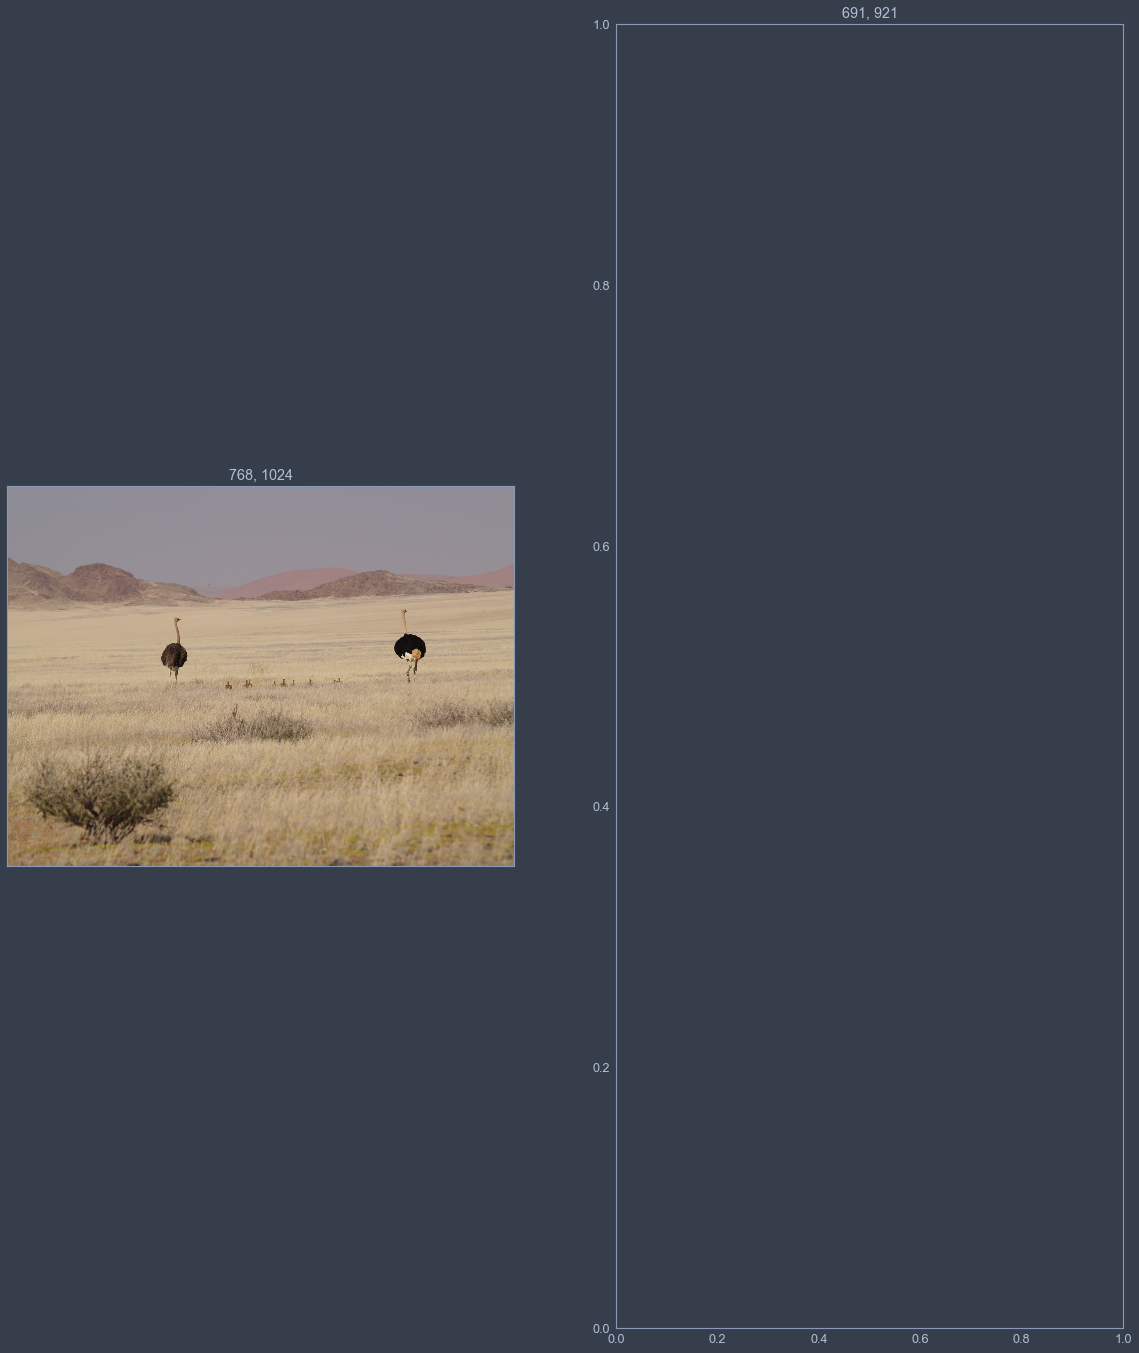

In [26]:
img = img1
shrink = 0.9

h, w, _ = img.shape


plt.figure(figsize=(20,24))

plt.subplot(121)
plt.title('{}, {}'.format(h, w))
plt.imshow(img / 255)
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.title('{}, {}'.format(int(h * shrink), int(w * shrink)))
img_resized = resize_image(img, int(h * shrink), int(w * shrink))
plt.imshow(img_resized / 255);
plt.xticks([]), plt.yticks([])

plt.show()


  8%|▊         | 46/599 [00:30<06:02,  1.53it/s]

KeyboardInterrupt: 

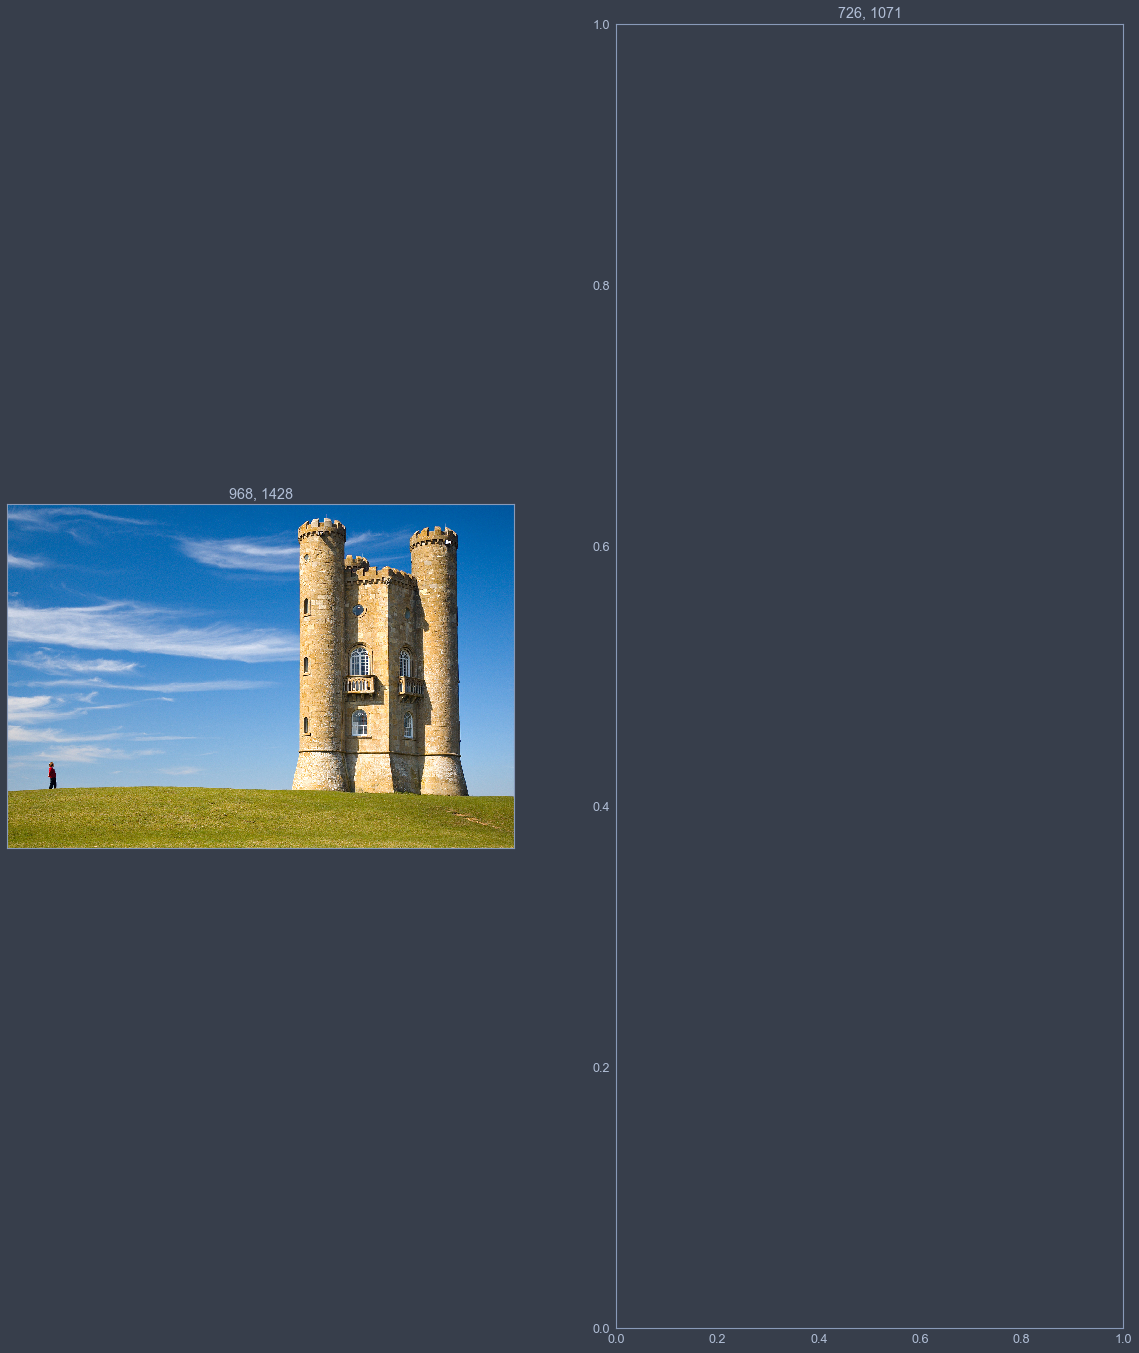

In [27]:
img = img2
shrink = 0.75

h, w, _ = img.shape

plt.figure(figsize=(20,24))

plt.subplot(121)
plt.title('{}, {}'.format(h, w))
plt.imshow(img / 255)
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.title('{}, {}'.format(int(h * shrink), int(w * shrink)))
img_resized = resize_image(img, int(h * shrink), int(w * shrink), True)
plt.imshow(img_resized / 255);
plt.xticks([]), plt.yticks([])

plt.show()